## Weather Classification
### Model Training

In [133]:
# The usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assemble pipeline(s)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# PMML Pipeline(s)
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline

# Models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

from feature_engine.imputation import CategoricalImputer

# Model Selection
from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold

In [134]:
# Dsplay pipelines
from sklearn import set_config
set_config(display="diagram")

In [135]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [136]:
from sklearn.model_selection import train_test_split

# Newspaper churn dataset
# It contains 15.855 records and 19 columns including the target variable Subscriber (YES/NO).
# The majority of the features is categorial.
df = pd.read_csv('../../../data/weather-classification-clean.csv')

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_test.sample(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
24816,2010-12-09,Region11,22.0,30.7,0.0,N,31.0,NE,SSE,13.0,9.0,80.0,62.0,1010.8,1008.2,7.0,8.0,23.4,28.3,No
7172,2013-06-09,Region3,5.9,20.8,0.0,NE,19.0,ESE,NNE,7.0,11.0,92.0,39.0,1026.5,1022.1,7.0,1.0,9.3,20.3,No
17897,2013-09-24,Region8,14.8,18.6,8.0,SSW,54.0,S,SSW,31.0,31.0,70.0,63.0,1008.6,1008.1,7.0,3.0,16.7,17.7,Yes
19470,2009-10-27,Region9,12.5,19.1,1.2,SSW,26.0,S,WNW,7.0,2.0,83.0,66.0,1018.5,1015.9,5.0,5.0,14.5,17.3,Yes
3415,2010-07-17,Region2,1.3,17.5,0.0,NNE,22.0,SW,NNE,9.0,13.0,83.0,45.0,1028.6,1024.6,5.0,5.0,8.2,16.6,No
11920,2011-11-09,Region5,20.5,34.2,0.0,NNE,41.0,N,NNW,26.0,11.0,56.0,25.0,1017.9,1013.9,6.0,3.0,23.8,33.2,No
7384,2014-02-06,Region3,19.8,35.7,0.0,ENE,43.0,ENE,E,22.0,17.0,38.0,23.0,1014.8,1010.7,4.0,1.0,22.5,33.4,No
14663,2012-04-13,Region7,14.4,22.9,0.0,W,22.0,W,E,9.0,15.0,74.0,65.0,1031.5,1028.7,5.0,5.0,18.4,21.0,No
8503,2009-03-02,Region4,21.4,26.5,0.0,S,33.0,SW,S,20.0,22.0,72.0,70.0,1014.7,1013.9,6.0,7.0,24.3,25.1,No
2299,2015-09-22,Region1,6.2,16.3,0.2,SW,41.0,WSW,SW,20.0,20.0,68.0,36.0,1021.8,1022.0,5.0,4.0,10.7,15.3,No


In [137]:
X_train.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
dtype: object

In [138]:
# Selecting categorical and numeric features
col_numerical = ['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Cloud9am','Cloud3pm']
col_categorical = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
col_datetime = ['Date']
col_drop = ['Date','Pressure3pm', 'Temp3pm', 'Temp9am']

In [139]:
col_categorical

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

## Ensemble of models

In [140]:
# Ensemble of models
estimator = []
estimator.append(('lrc',LogisticRegression(warm_start=True, max_iter=400)))
estimator.append(('xgb', XGBClassifier(tree_method="hist", verbosity=0, silent=True)))
estimator.append(('rfc', RandomForestClassifier()))
estimator.append(('dtc', DecisionTreeClassifier()))

In [141]:
from sklearn.feature_selection import VarianceThreshold
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn2pmml.decoration import ContinuousDomain, OrdinalDomain
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.selection import DropFeatures
from feature_engine.datetime import DatetimeFeatures

ppl_ensemble = Pipeline([
    # Step 1: Feature Engineering
    #('conv_datetime', DatetimeFeatures(features_to_extract=['year','month','day_of_month'], variables=col_datetime, missing_values='ignore')),
    ('drop_constant', VarianceThreshold()),

    # Step 2: Impute and scale features
    ('cleaning', ColumnTransformer([
        # Step 2.1: Apply steps for numerical features
        ('num',make_pipeline(
            SimpleImputer(strategy='median'),
            StandardScaler()),
         col_numerical),
        # Step 2.2 Apply steps for categorial features
        ('cat',make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(handle_unknown = 'ignore')),
         col_categorical)])
     ),

    # Step 3: Features scaling
   # ('scaler', StandardScaler()),

    # Step 4: Voting Classifier
    ('ensemble', VotingClassifier(estimators = estimator, voting ='soft'))

])

In [142]:
display(ppl_ensemble)

Pipeline(steps=[('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Cloud9am',
                                                   'Cloud3pm']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimp...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location', 'WindGustDir',
                                                   'WindDir9am', 'WindDir3pm',
                                                   'RainToday'])])),
                ('ensemble',
                 VotingClassifier(estimators=[('lrc',
                                               LogisticRegression(max_iter=400,
                                                                  warm_start=True)),
                                              ('xgb',
                                               XGBClassifier(silent=True,
                                                             tree_method='hist',
                                                             verbosity=0)),
                                              ('rfc', RandomForestClassifier()),
                                              ('dtc',
                                               DecisionTreeClassifier())],
                                  voting='soft'))])

## Hyper-parameter Tuning

In [143]:
ppl_ensemble.get_params()

{'memory': None,
 'steps': [('cleaning', ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['MinTemp', 'MaxTemp', 'Rainfall',
                                     'WindGustSpeed', 'WindSpeed9am',
                                     'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                                     'Pressure9am', 'Cloud9am', 'Cloud3pm']),
                                   ('cat',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                    

In [144]:
# Hyper-parameter
hyper_params = {
    'ensemble__lrc__solver': ['newton-cg'],
    'ensemble__xgb__reg_alpha': [0.1,0.5],
    'ensemble__rfc__max_depth': [7,10],
    'ensemble__dtc__max_depth': [7,10]
}

cv_rsf = RepeatedStratifiedKFold(n_splits=2, n_repeats=1)

In [145]:
# Create pipeline with logistic regression as classifier
ppl_tuning = PMMLPipeline(steps=[
    ('hyper-tuning', RandomizedSearchCV(ppl_ensemble, param_distributions=hyper_params, scoring='roc_auc', verbose=2, cv=cv_rsf))
])

ppl_tuning.fit(X_train, y_train)
ppl_tuning.verify(X_train.sample(n = 10))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.1; total time=   1.7s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.1; total time=   1.7s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.5; total time=   1.7s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.5; total time=   1.6s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=10, ensemble__xgb__reg_alpha=0.1; total time=   2.5s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=10, ensemble__xgb__reg_alpha=0.1; total time=   2.7s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solv

In [146]:
# summarize result
# print('Best Score: %s' % ppl_tuning.best_score_)
# print('Best Hyperparameters: %s' % ppl_tuning.best_params_)

In [147]:
y_pred = ppl_tuning.predict(X_test)

In [148]:
# using accuracy_score
from sklearn.metrics import f1_score

print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model accuracy is: 84.6%
The model f1 score is: 82.89999999999999%


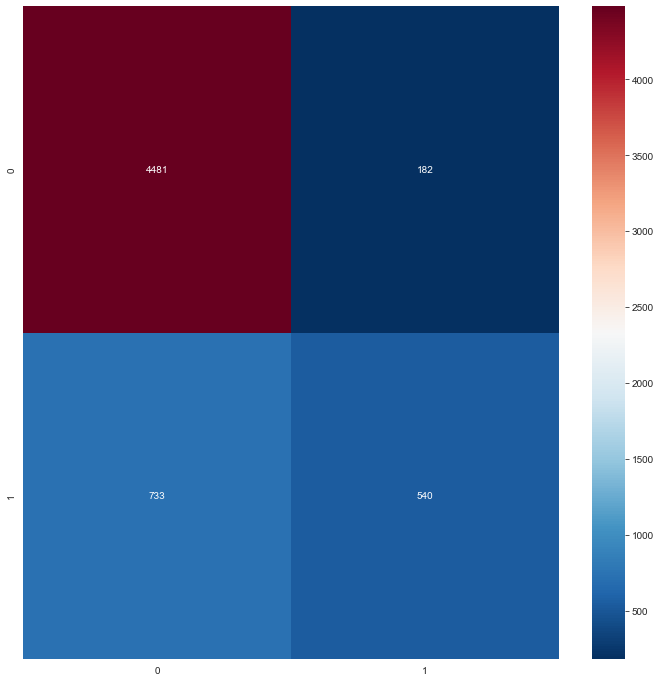

In [149]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=ppl_tuning.classes_)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", xticklabels=ppl_tuning.classes_, yticklabels=ppl_tuning.classes_, fmt='g', annot=True)
plt.show()

<Figure size 2160x2160 with 0 Axes>

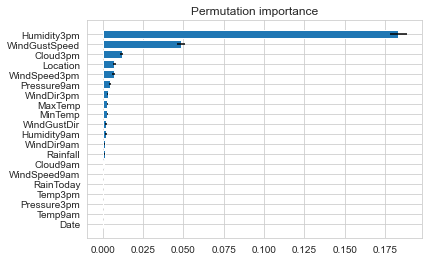

In [150]:
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html
def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """
    plt.figure(figsize=(30, 30))
    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    tmp = np.array(feat_name)
    ax.set_yticklabels(tmp[indices])
    ax.set_title("Permutation importance")

ppl_ensemble.fit(X_test,y_test)
features = ppl_ensemble.feature_names_in_
perm_importance_result_train = permutation_importance(ppl_tuning, X_test, y_test)
plot_feature_importances(perm_importance_result_train, features)

## Save the model

In [151]:
# Save the best model in PMML format
sklearn2pmml(ppl_tuning, "../../../data/weather-classification-ensemble-classifier.pmml")